# Basic ML example

Here, we reimplement sklearn [example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html#sphx-glr-auto-examples-linear-model-plot-sparse-logistic-regression-mnist-py) as Function Fuse workflow .

## The workflow

In [1]:


from functionfuse import workflow
from functionfuse.backends.builtin.localback import LocalWorkflow
from functionfuse.storage import storage_factory



@workflow
def openml_dataset():
    from sklearn.datasets import fetch_openml
    from sklearn.utils import check_random_state

    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas")
    random_state = check_random_state(0)
    permutation = random_state.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    X = X.reshape((X.shape[0], -1))
    return X, y


@workflow
def train_test_split(X, y, train_samples, test_size):
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_samples, test_size=test_size
    )
    return {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}

@workflow
def train_model(X, y):
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline
    from sklearn.linear_model import LogisticRegression

    train_samples = len(X)
    clf = make_pipeline(StandardScaler(), LogisticRegression(C=50.0 / train_samples, penalty="l1", solver="saga", tol=0.1))
    clf.fit(X, y)
    return clf


dataset = openml_dataset().set_name("dataset")
X, y = dataset[0], dataset[1]
dataset_split = train_test_split(X, y, train_samples = 5000, test_size = 10000).set_name("dataset_split")
model = train_model(dataset_split["X_train"], dataset_split["y_train"]).set_name("model")

local_workflow = LocalWorkflow(dataset, workflow_name="classifier")
opt = {
    "kind": "file",
    "options": {
        "path": "storage"
    }
}
storage = storage_factory(opt)
local_workflow.set_storage(storage)
_ = local_workflow.run()


## Model Prediction

The code above is designed to train models and save the workflow data in the storage. Typically this code should be placed in a separate Python module. We placed the workflow code in the Jupyter Notebook for demonstration purposes only. Final model analysis and data visualization are performed from the stored data in the Jupyter Notebook as shown below.

In [2]:
import pprint
from functionfuse.storage import storage_factory

the_workflow_name = "classifier"
storage_path = "storage"
opt = {
    "kind": "file",
    "options": {
        "path": storage_path
    }
}
storage = storage_factory(opt)
all_tasks = storage.list_tasks(workflow_name=the_workflow_name, pattern="*")

pp = pprint.PrettyPrinter(width=141, compact=True)
print("All graph node names: ")
pp.pprint(all_tasks)

All graph node names: 
['dataset', 'dataset_split', 'model']


Sparsity with L1 penalty: 76.73%
Test score with L1 penalty: 0.8228


Text(0.5, 0.98, 'Classification vector for...')

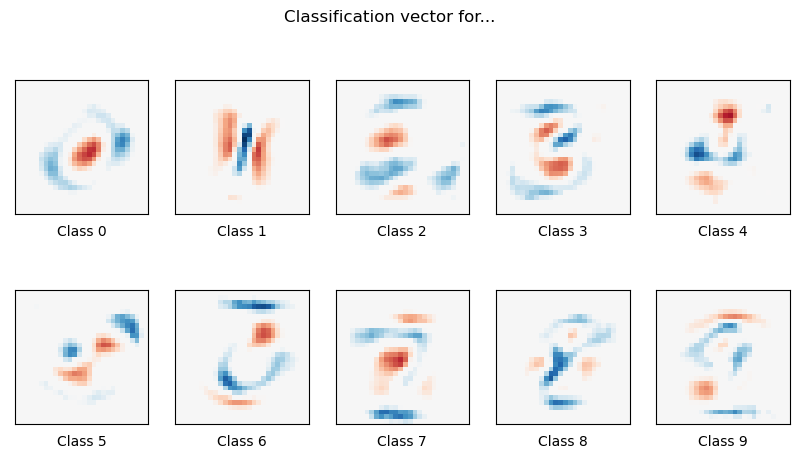

In [3]:
import numpy as np
import matplotlib.pyplot as plt

clf = storage.read_task(workflow_name=the_workflow_name, task_name="model")
dataset_split = storage.read_task(workflow_name=the_workflow_name,  task_name="dataset_split")
X_test, y_test = dataset_split["X_test"], dataset_split["y_test"]

lr = clf.named_steps["logisticregression"]

sparsity = np.mean(lr.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)
 


coef = lr.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        coef[i].reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,
        vmin=-scale,
        vmax=scale,
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Class %i" % i)
plt.suptitle("Classification vector for...")